In [1]:
!pip install pandas==1.3.4
!pip install transformers==4.12.5
!pip install datasets==1.15.1
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import os
import pickle

from collections import Counter

# import pandas as pd
from sklearn.metrics import classification_report

import numpy as np
import torch
import torch.nn as nn

import transformers
from transformers import Trainer
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers.data.data_collator import DataCollatorWithPadding

import datasets
from datasets import Dataset
from datasets import ClassLabel
from datasets import load_metric

## Global variables

In [3]:
DATA_FOLDER = '/notebooks/Data/bert_sequence_classification'
DATA_FILE = '/notebooks/linguistic_features/data/hf_datasets/pe_dataset_linguistic_features.pt'
RESULTS_FOLDER = '/notebooks/Results/bert_sequence_classification'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

## Load data

In [6]:
dataset = torch.load(DATA_FILE)

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['essay_nr', 'component_id', 'label_and_comp_idxs', 'text', 'label_x', 'label_ComponentType', 'relation_SupportAttack', 'label_RelationType', 'label_LinkedNotLinked', 'split', 'essay', 'argument_bound_1', 'argument_bound_2', 'argument_id', 'sentence', 'paragraph', 'para_nr', 'total_paras', 'token_count', 'token_count_covering_para', 'tokens_count_covering_sentence', 'preceeding_tokens_in_sentence_count', 'succeeding_tokens_in_sentence_count', 'token_ratio', 'relative_position_in_para_char', 'is_in_intro', 'relative_position_in_para_token', 'is_in_conclusion', 'is_first_in_para', 'is_last_in_para', 'nr_preceeding_comps_in_para', 'nr_following_comps_in_para', 'structural_fts_as_text', 'structural_fts_as_text_combined', 'component_POS', 'strct_fts_and_component_pos', 'sentence_POS', 'strct_fts_and_sentence_pos', 'component_syn_deps', 'strct_fts_and_component_syn_deps', 'sentence_syn_deps', 'strct_fts_and_sentence_syn_deps', 'strct_pos_s

In [8]:
dataset['train']['strct_fts_and_component_pos'][230]

"Topic: Young people should go to university or not, Sentence: Although higher education does not guarantee young students' success, the benefits of learning in universities are the vital factor in creating more possibilities for the development of society through advancing academic fulfillment and the young generation who have experiences and challenges., Para Number: 4, First in Para: No, Last in Para: Yes, Is in Introduction: No, Is in Conclusion: Yes. Part Of Speech tags: DET, NOUN, ADP, VERB, ADP, NOUN, AUX, DET, ADJ, NOUN, ADP, VERB, ADJ, NOUN, ADP, DET, NOUN, ADP, NOUN, ADP, VERB, ADJ, NOUN, CCONJ, DET, ADJ, NOUN, PRON, AUX, NOUN, CCONJ, NOUN"

In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [10]:
label_names = set(dataset['train']['label_ComponentType'])
label_nb = len(label_names)
labels = ClassLabel(num_classes=label_nb, names=label_names)

In [11]:
labels

ClassLabel(num_classes=3, names={'Premise', 'MajorClaim', 'Claim'}, names_file=None, id=None)

In [12]:
def tokenize(batch):
    tokens = tokenizer(batch['strct_fts_and_component_pos'], truncation=True, padding=True, max_length=512)
    tokens['labels'] = labels.str2int(batch['label_ComponentType'])
    return tokens

In [13]:
dataset = dataset.map(tokenize, batched=True)

Parameter 'function'=<function tokenize at 0x7f2894059700> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [14]:
dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['argument_bound_1', 'argument_bound_2', 'argument_id', 'attention_mask', 'component_POS', 'component_id', 'component_syn_deps', 'essay', 'essay_nr', 'input_ids', 'is_first_in_para', 'is_in_conclusion', 'is_in_intro', 'is_last_in_para', 'label_ComponentType', 'label_LinkedNotLinked', 'label_RelationType', 'label_and_comp_idxs', 'label_x', 'labels', 'nr_following_comps_in_para', 'nr_preceeding_comps_in_para', 'para_nr', 'paragraph', 'preceeding_tokens_in_sentence_count', 'relation_SupportAttack', 'relative_position_in_para_char', 'relative_position_in_para_token', 'sentence', 'sentence_POS', 'sentence_syn_deps', 'split', 'strct_fts_and_component_pos', 'strct_fts_and_component_syn_deps', 'strct_fts_and_sentence_pos', 'strct_fts_and_sentence_syn_deps', 'strct_pos_syn_deps_component', 'strct_pos_syn_deps_sentence', 'structural_fts_as_text', 'structural_fts_as_text_combined', 'succeeding_tokens_in_sentence_count', 'text', 'token_count', '

In [16]:
train_dataset = dataset['train'].shuffle(seed=42)
test_dataset = dataset['test'].shuffle(seed=42)

train_val_datasets = dataset['train'].train_test_split(train_size=0.8, seed=42)
train_dataset = train_val_datasets['train']
val_dataset = train_val_datasets['test']

In [17]:
dataset_d = {}
dataset_d['train'] = train_dataset
dataset_d['test'] = test_dataset
dataset_d['val'] = val_dataset

In [18]:
tokenizer.decode(dataset['train'][2945]['input_ids'])

'[CLS] topic : zoos have no useful purpose?, sentence : in the zoo you can see an animal and their different variations, the male and the female or the baby and the adult, para number : 3, first in para : no, last in para : no, is in introduction : no, is in conclusion : no. part of speech tags : adp, det, noun, pron, verb, verb, det, noun, cconj, det, adj, noun, punct, det, noun, cconj, det, noun, cconj, det, noun, cconj, det, noun [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [19]:
# sanity check
set(dataset_d['train']['split'])

{'TRAIN'}

In [20]:
# sanity check
set(dataset_d['val']['split'])

{'TRAIN'}

In [21]:
# sanity check
set(dataset_d['test']['split'])

{'TEST'}

In [22]:
# global variables
NUM_LABELS = labels.num_classes
BATCH_SIZE = 24
NB_EPOCHS = 6

In [23]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [24]:
counter = Counter(dataset_d['train']['labels'].tolist())

In [25]:
class_weights = [max(counter.values()) / counter[k] for k in sorted(counter.keys())]
class_weights = torch.FloatTensor(class_weights)#.to(device)

In [26]:
class_weights

tensor([1.0000, 5.3056, 2.5603])

In [27]:
total_weights = torch.sum(class_weights)

In [28]:
norm_weights = [class_weights[i] / total_weights for i in [0, 1, 2]]

In [29]:
norm_weights = torch.FloatTensor(norm_weights)

In [30]:
norm_weights

tensor([0.1128, 0.5984, 0.2888])

In [31]:
class SoftMacroF1(nn.Module):
    
    def __init__(self, weights):
        super(SoftMacroF1, self).__init__()
        self.weights = weights

    def forward(self, predictions, targets):
        """
        Computes differentiable macro F1 score.

        Parameters
        ----------
        predictions : torch.Tensor
            tensor of predictions (float, 2D)

        targets : torch.Tensor
            tensor of targets (integers, 1D)

        Returns
        -------
        cost : torch.Tensor
            1 - differentiable macro F1 (0D, i.e., value)
        """
        dim = predictions.shape[1]
        soft_f1s = torch.zeros(size=(dim,))
        
        predictions = torch.nn.Softmax(dim=1)(predictions)

        for i in range(dim):

            targets_tmp = targets == i

            targets_tmp = targets_tmp.float()
            # predictions_i = predictions[:, i].float()

            tp = torch.sum(predictions[:, i] * targets_tmp, axis=0)
            fp = torch.sum(predictions[:, i] * (1 - targets_tmp), axis=0)
            fn = torch.sum((1 - predictions[:, i]) * targets_tmp, axis=0)
            soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
            soft_f1s[i] = soft_f1
            
        #macro_f1 = torch.div((soft_f1s @ self.weights), len(soft_f1s)) # weighted
        
        macro_f1 = soft_f1s @ self.weights

        # macro_f1 = torch.mean(soft_f1s, axis=0) # simgple
        
        # special_macro_f1 = torch.weighted_mean(soft_f1s, axis=0, weights=[0.4, 0.5, 0.1])

        cost = 1 - macro_f1 # reduce 1 - soft-f1 in order to increase soft-f1

        # macro_cost = tf.reduce_mean(cost) # average on all labels

        return cost

In [32]:
# https://huggingface.co/transformers/main_classes/trainer.html
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = SoftMacroF1(weights=class_weights)#nn.CrossEntropyLoss()#(weight=class_weights)
        # added softmax here. but then put it in the loss class.
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [33]:
metric = load_metric('f1')

def compute_metrics(eval_pred):
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    return metric.compute(predictions=predictions, references=labels, average='macro')

In [34]:
training_args = TrainingArguments(
    
    # output
    output_dir=RESULTS_FOLDER,          
    
    # params
    num_train_epochs=NB_EPOCHS,               # nb of epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # cf. paper Sun et al.
    learning_rate=1e-5,#2e-5,                 # cf. paper Sun et al.
#     warmup_steps=500,                         # number of warmup steps for learning rate scheduler
    warmup_ratio=0.1,                         # cf. paper Sun et al.
    weight_decay=0.01,                        # strength of weight decay
    
    # eval
    evaluation_strategy="steps",              # cf. paper Sun et al.
    eval_steps=20,                            # cf. paper Sun et al.
    
    # log
    logging_dir="/notebooks/linguistic_features/notebooks/CustLoss_TF_Results",  
    logging_strategy='steps',
    logging_steps=20,
    
    # save
    save_strategy='steps',
    save_total_limit=2,
    # save_steps=20, # default 500
    load_best_model_at_end=True,              # cf. paper Sun et al.
    # metric_for_best_model='eval_loss' 
    metric_for_best_model='f1'
)

In [35]:
trainer = CustomTrainer( # Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

In [36]:
results = trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: is_first_in_para, label_and_comp_idxs, total_paras, para_nr, strct_fts_and_component_pos, component_id, label_x, essay_nr, strct_fts_and_sentence_pos, is_in_intro, nr_following_comps_in_para, nr_preceeding_comps_in_para, strct_pos_syn_deps_component, paragraph, component_syn_deps, strct_fts_and_component_syn_deps, token_count_covering_para, label_RelationType, label_ComponentType, relation_SupportAttack, argument_id, is_last_in_para, argument_bound_1, sentence_POS, succeeding_tokens_in_sentence_count, argument_bound_2, token_ratio, preceeding_tokens_in_sentence_count, component_POS, is_in_conclusion, structural_fts_as_text, strct_fts_and_sentence_syn_deps, text, label_LinkedNotLinked, relative_position_in_para_char, split, strct_pos_syn_deps_sentence, token_count, essay, sentence, sentence_syn_deps, relative_position_in_para_token, structural_

Step,Training Loss,Validation Loss,F1
20,-1.081800,-1.074124,0.074862
40,-1.009100,-1.154821,0.468048
60,-1.078200,-1.466393,0.466660
80,-1.737800,-2.790278,0.644951
100,-2.688800,-3.891407,0.650864
120,-3.876500,-4.466651,0.712125
140,-3.760200,-4.426193,0.698088
160,-4.242000,-4.856114,0.712656
180,-4.497400,-4.815828,0.691450
200,-5.038000,-4.769930,0.716208


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: is_first_in_para, label_and_comp_idxs, total_paras, para_nr, strct_fts_and_component_pos, component_id, label_x, essay_nr, strct_fts_and_sentence_pos, is_in_intro, nr_following_comps_in_para, nr_preceeding_comps_in_para, strct_pos_syn_deps_component, paragraph, component_syn_deps, strct_fts_and_component_syn_deps, token_count_covering_para, label_RelationType, label_ComponentType, relation_SupportAttack, argument_id, is_last_in_para, argument_bound_1, sentence_POS, succeeding_tokens_in_sentence_count, argument_bound_2, token_ratio, preceeding_tokens_in_sentence_count, component_POS, is_in_conclusion, structural_fts_as_text, strct_fts_and_sentence_syn_deps, text, label_LinkedNotLinked, relative_position_in_para_char, split, strct_pos_syn_deps_sentence, token_count, essay, sentence, sentence_syn_deps, relative_position_in_para_token, structura

In [37]:
torch.cuda.empty_cache()

In [38]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [39]:
test_trainer = Trainer(model, data_collator=DataCollatorWithPadding(tokenizer))
test_raw_preds, test_labels, _ = test_trainer.predict(test_dataset)
test_preds = np.argmax(test_raw_preds, axis=1)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: is_first_in_para, label_and_comp_idxs, total_paras, para_nr, strct_fts_and_component_pos, component_id, label_x, essay_nr, strct_fts_and_sentence_pos, is_in_intro, nr_following_comps_in_para, nr_preceeding_comps_in_para, strct_pos_syn_deps_component, paragraph, component_syn_deps, strct_fts_and_component_syn_deps, token_count_covering_para, label_RelationType, label_ComponentType, relation_SupportAttack, argument_id, is_last_in_para, argument_bound_1, sentence_POS, succeeding_tokens_in_sentence_

In [40]:
len(test_preds)

1260

In [41]:
target_name = labels.int2str([0,1,2])
print(classification_report(test_labels, test_preds, target_names=target_name, digits=3))

              precision    recall  f1-score   support

     Premise      0.891     0.906     0.898       805
  MajorClaim      0.757     0.915     0.828       153
       Claim      0.669     0.570     0.615       302

    accuracy                          0.826      1260
   macro avg      0.772     0.797     0.781      1260
weighted avg      0.822     0.826     0.822      1260



In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
confusion_matrix(test_labels, test_preds)

array([[729,   3,  73],
       [  1, 140,  12],
       [ 88,  42, 172]])

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay

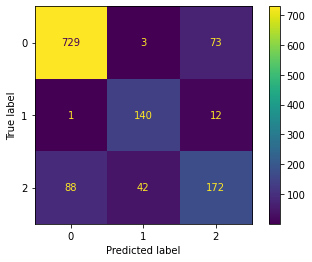

In [45]:
ConfusionMatrixDisplay.from_predictions(test_labels, test_preds)

In [46]:
test_labels

array([1, 0, 2, ..., 2, 0, 0])

In [47]:
test_preds

array([1, 0, 2, ..., 0, 2, 0])